In [0]:
'Please Enter your DOT Email address.'
user_email_address = 'your.name@dot.gov'

In [0]:
import json

# Revise the directory path. We recommend to create git_clone under your Workspace directory. 
# Modify the 'paths' dictionary if you want to create under nested directory in Workspace.

# Define paths
paths = {
    "Requirement_path": f'/Workspace/Users/{user_email_address}/CHARISMA/environment/requirements.txt',
    "Code_path": f'/Workspace/Users/{user_email_address}/CHARISMA/ground-penetrating-radar/code',
    "Data_path": f'/Workspace/Users/{user_email_address}/CHARISMA/ground-penetrating-radar/data/'
}

# Save paths to a JSON file
with open('paths.json', 'w') as f:
    json.dump(paths, f)

In [0]:
# Install CHARISMA
%pip install -r "{paths['Requirement_path']}"

# Restart Kernel
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached pandas-2.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached matplotlib-3.8.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl.metadata (57 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl.metadata (9.2 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manyli

In [0]:
# Since we restarted kernel
import json

# Load paths from the JSON file
with open('paths.json', 'r') as f:
    paths = json.load(f)

# Retrieve individual paths
Code_path = paths["Code_path"]
Data_path = paths["Data_path"]

In [0]:
import sys 
sys.path.append(Code_path)
import GPR_locate_rebars as gpr_lr

In [0]:
# Save DZT into CSV files
downloaded_path = Data_path
df1, df2 = gpr_lr.readdzt(downloaded_path + "Mississippi_bridge_data.DZT")
gpr_lr.save_to_csv(df1, downloaded_path, 'data')
gpr_lr.save_to_csv(df2, downloaded_path, 'config')

In [0]:
# Read saved CSV file
user_directory = Data_path
df_1, df_2 = gpr_lr.read_csv(user_directory)

In [0]:
# Allocate all the GPR configuration settings as variables in Python
result_variables = gpr_lr.config_to_variable(df_2)
locals().update(result_variables)

In [0]:
# Outlier removal through IQR
IQR_df_1 = gpr_lr.Interquartile_Range(df_1, min_value=0.10, max_value=0.95, multiplier=1.5)

In [0]:
# Split the DataFrame (too long column)
clipped_df_chunk=gpr_lr.data_chunk(IQR_df_1)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-6b42927b-7bda-475b-bd84-342bf98e3b65/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


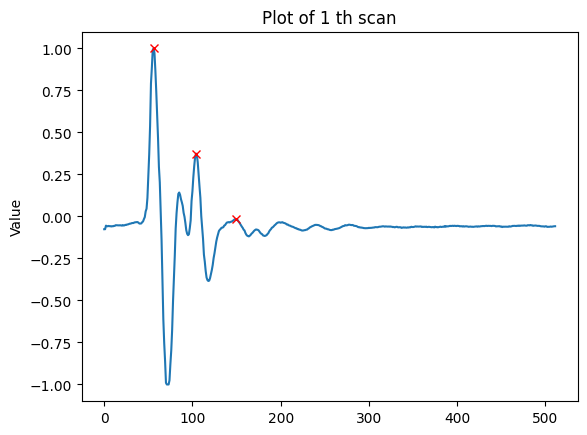

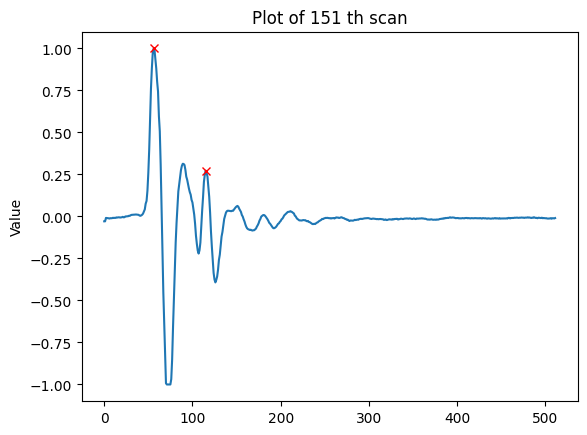

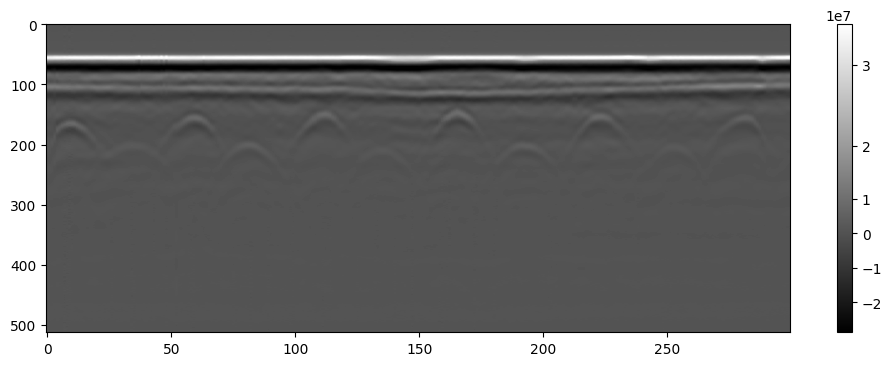

In [0]:
# Plot A-scans and B-scan of the data (Outlier removed & coulmn cut)
gpr_lr.plot.Plot_a_scan(clipped_df_chunk[0])
gpr_lr.plot.Plot_b_scan_advanced(clipped_df_chunk[0], 0.7)

In [0]:
# Apply power gain 
gpr_data_powered = gpr_lr.power_gain_dataframe(clipped_df_chunk[0], type="pow", alpha=0.4, t0=120)

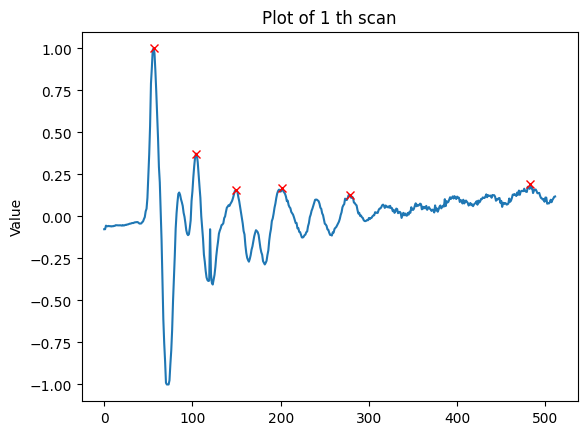

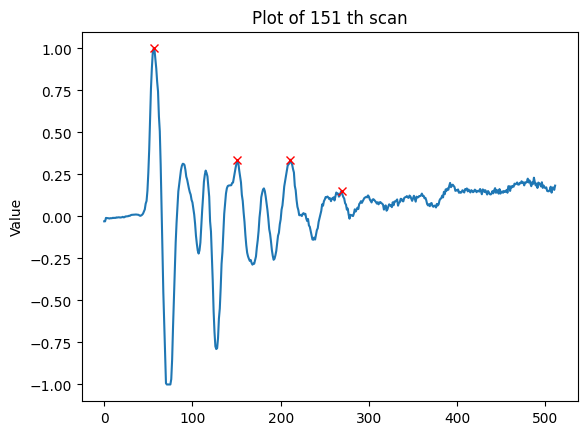

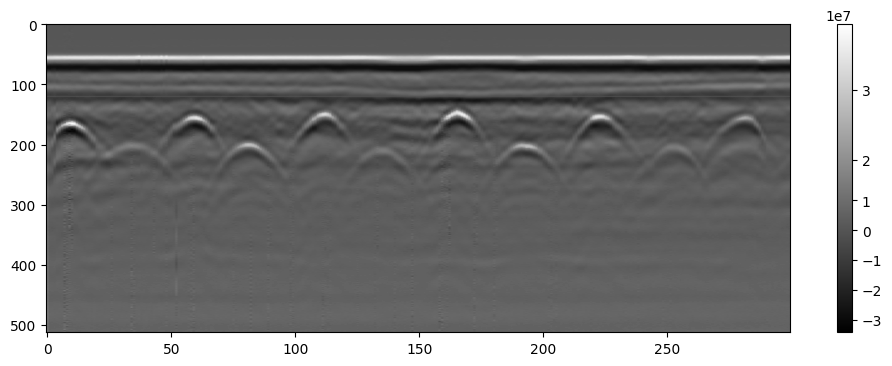

In [0]:
# Plot A-scans and B-scan of the data after gain
gpr_lr.plot.Plot_a_scan(gpr_data_powered)
gpr_lr.plot.Plot_b_scan_advanced(gpr_data_powered, 0.7)

In [0]:
# Apply trinomial dewow function
dewowed_ar = gpr_lr.dewow(gpr_data_powered)

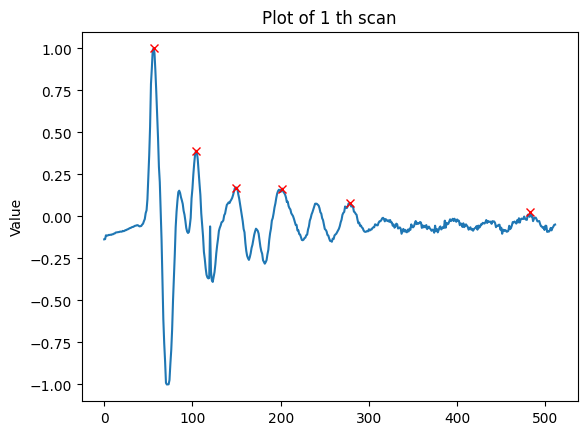

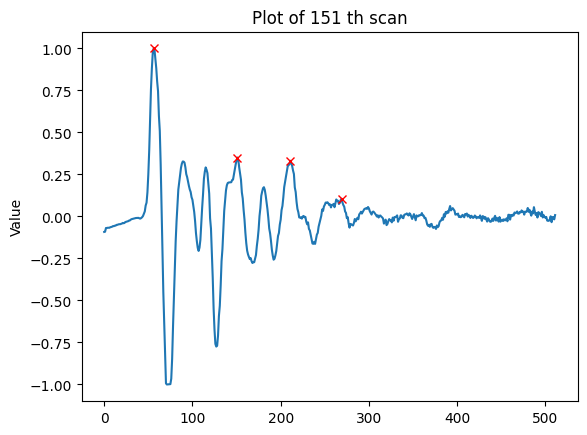

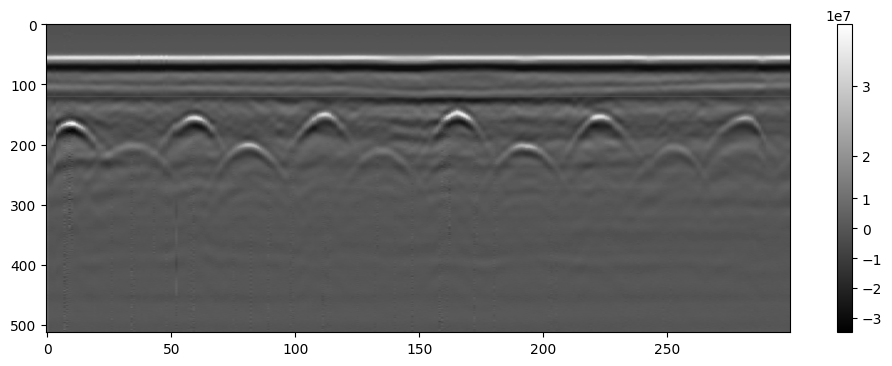

In [0]:
# Plot A-scans and B-scan of the data after dewow
gpr_lr.plot.Plot_a_scan(dewowed_ar)
gpr_lr.plot.Plot_b_scan_advanced(dewowed_ar, 0.7)

In [0]:
# Apply scan-by-scan time-zero correction
time0df, rh_nsamp = gpr_lr.Timezero_individual(dewowed_ar, rhf_position, rhf_range)

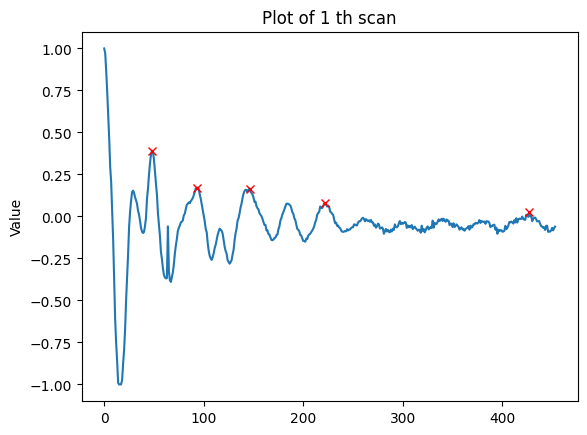

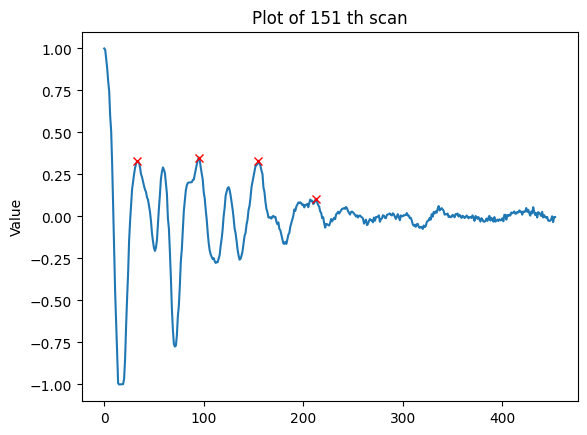

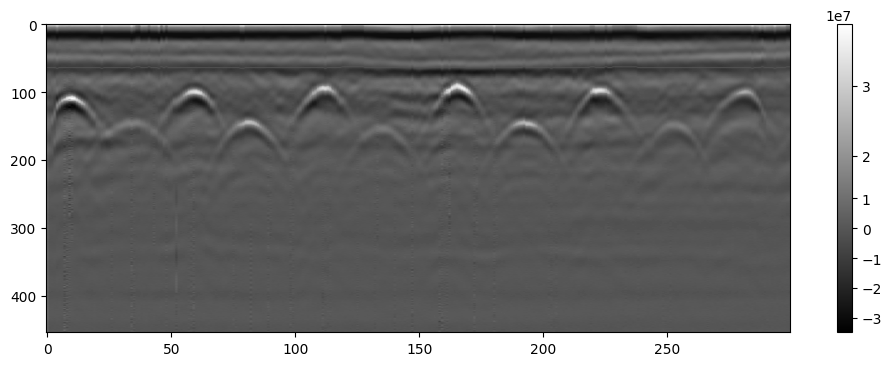

In [0]:
# Plot A-scans and B-scan of the time-zeroed data
gpr_lr.plot.Plot_a_scan(time0df)
gpr_lr.plot.Plot_b_scan_advanced(time0df, 0.7)

In [0]:
# Migration
migrated_df, profilePos, dt, dx, velocity = gpr_lr.FK_migration(time0df, rhf_spm, rhf_sps, rhf_position, rhf_range, rh_nsamp, rhf_espr=10)

512it [00:00, 5678.06it/s]


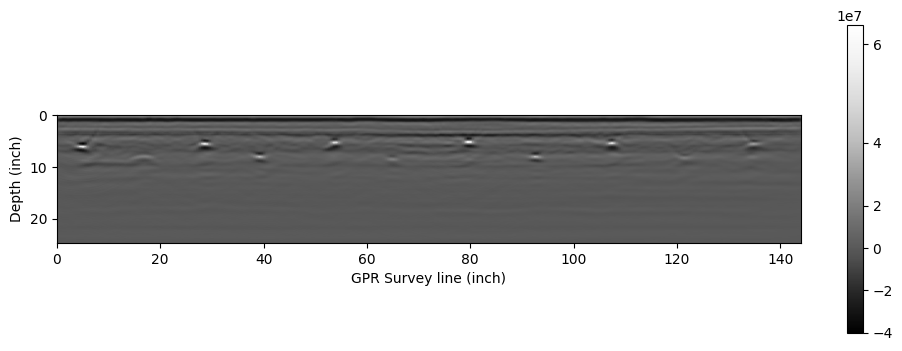

In [0]:
# Plot migrated data
gpr_lr.plot.Plot_migrated_advanced(migrated_df, profilePos, velocity, rhf_range, rh_nsamp, 0.7)

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

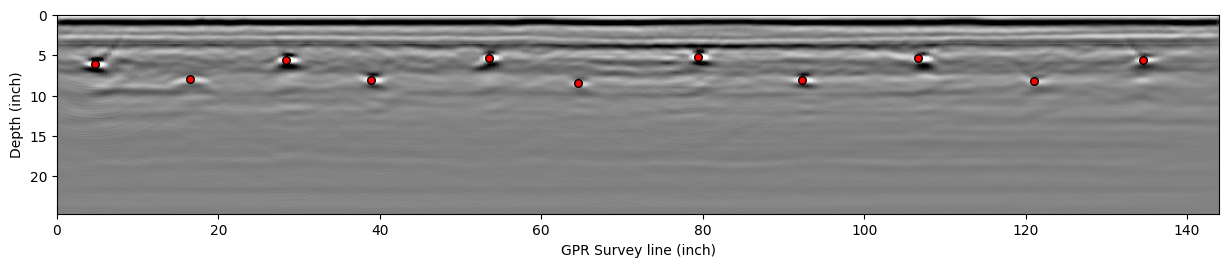

In [0]:
# Locate rebar configuration based on the migration result
gpr_lr.locate_rebar_consecutive(migrated_df, velocity, rhf_range, rh_nsamp, profilePos, vmin=0.15, vmax=0.7, amplitude_threshold=0.55, depth_threshold=8, minimal_y_index=90, num_clusters=11, random_state=42, redundancy_filter=0.6)